In [1]:
import numpy as np
import pandas as pd
import pandasql as sql
import holidays
import pandas_profiling as prof
from itertools import chain
from statsmodels.tsa.arima_model import ARIMA
import datetime
import geopandas as gpd
import libpysal as pysal
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import Queen, Rook, KNN
import esda as esda
from sklearn.model_selection import train_test_split
from shapely.geometry import Point, Polygon, LineString
import cartopy as carto
import cartopy.crs as ccrs
import contextily as ctx
import pyproj
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import geobr
import geoplot
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify as mc
plt.style.use('classic')
%matplotlib inline
from splot.esda import moran_scatterplot
np.random.seed(12345)
import os
os.chdir("C:\\Users\\Caio Serrano\\Google Drive\\4-MacBook Pro\\Py - Codes\\DataScienceGit\\DataScienceProjects\\Geospatial\\dataset")
ibge = gpd.read_file('../dataset/BR_Localidades_2010_v1.shp')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



In [2]:
cust = pd.read_csv('../dataset/olist_customers_dataset.csv')
geo = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
ord_itens = pd.read_csv('../dataset/olist_order_items_dataset.csv')
ord_pymt = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
ord_rev = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
fact_ord = pd.read_csv('../dataset/olist_orders_dataset.csv')
prdts = pd.read_csv('../dataset/olist_products_dataset.csv')
seller = pd.read_csv('../dataset/olist_sellers_dataset.csv')

In [3]:
##geo_poly = geo.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).agg(list).apply(lambda x: tuple(chain.from_iterable(zip(x['geolocation_lng'], x['geolocation_lat']))), axis=1).reset_index(name='geometry')
geo_avg = sql.sqldf("""
                SELECT
                geolocation_zip_code_prefix geolocation_zip_code_prefix,
                geolocation_city geolocation_city,
                geolocation_state geolocation_state,
                AVG(geolocation_lat) geolocation_lat,
                AVG(geolocation_lng) geolocation_lng
                FROM geo f
                GROUP BY 1,2,3
                """)

geo_poly_sp = sql.sqldf("""
                SELECT
                *
                FROM
                (
                    SELECT
                    geolocation_zip_code_prefix geolocation_zip_code_prefix,
                    geolocation_city geolocation_city,
                    geolocation_state geolocation_state,
                    geolocation_lat geolocation_lat,
                    geolocation_lng geolocation_lng,
                    COUNT(CAST(geolocation_lat AS VARCHAR(1000)) + '-' + CAST(geolocation_lng AS VARCHAR(1000))) poly_check
                    FROM geo f
                    GROUP BY 1,2,3,4,5
                )
                WHERE poly_check >= 3
                AND geolocation_state = 'SP'
                """)

geo_gpds = gpd.GeoDataFrame(geo_avg, geometry = gpd.points_from_xy(geo_avg.geolocation_lng,geo_avg.geolocation_lat))
#geo_gpds['geometry'] = geo_gpds['geometry'].apply(lambda x: x.coords[0])
#geo_gpds = geo_gpds.groupby('geolocation_zip_code_prefix')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()
#geo_gpds = gpd.GeoDataFrame(df, geometry = 'geometry')
#geo_gpds.plot(figsize=(20,10))

In [4]:
query = sql.sqldf("""
                SELECT
                f.order_id order_nr,
                f.*,
                it.*,
                prdts.*,
                s.*,
                c.*,
                p.*,
                r.*
                FROM fact_ord f
                LEFT JOIN ord_itens it ON f.order_id = it.order_id
                LEFT JOIN prdts prdts ON it.product_id = prdts.product_id
                LEFT JOIN seller s ON it.seller_id = s.seller_id
                LEFT JOIN cust c ON f.customer_id = c.customer_id
                LEFT JOIN ord_pymt p ON f.order_id = p.order_id
                LEFT JOIN ord_rev r ON f.order_id = r.order_id
                """)

orders = pd.DataFrame(query)

In [5]:
orders.drop(columns=['order_id'], inplace=True)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_purchase_year'] = orders['order_purchase_timestamp'].dt.year
orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['order_purchase_day'] = orders['order_purchase_timestamp'].dt.day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].dt.hour
orders['order_purchase_minute'] = orders['order_purchase_timestamp'].dt.minute
orders['order_purchase_weekday'] = orders['order_purchase_timestamp'].dt.day_name()

orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_approved_at_year'] = orders['order_approved_at'].dt.year
orders['order_approved_at_month'] = orders['order_approved_at'].dt.month
orders['order_approved_at_day'] = orders['order_approved_at'].dt.day
orders['order_approved_at_hour'] = orders['order_approved_at'].dt.hour
orders['order_approved_at_minute'] = orders['order_approved_at'].dt.minute
orders['order_approved_at_weekday'] = orders['order_approved_at'].dt.day_name()

orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_carrier_date_year'] = orders['order_delivered_carrier_date'].dt.year
orders['order_delivered_carrier_date_month'] = orders['order_delivered_carrier_date'].dt.month
orders['order_delivered_carrier_date_day'] = orders['order_delivered_carrier_date'].dt.day
orders['order_delivered_carrier_date_hour'] = orders['order_delivered_carrier_date'].dt.hour
orders['order_delivered_carrier_date_minute'] = orders['order_delivered_carrier_date'].dt.minute
orders['order_delivered_carrier_date_weekday'] = orders['order_delivered_carrier_date'].dt.day_name()

orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_estimated_delivery_date_year'] = orders['order_estimated_delivery_date'].dt.year
orders['order_estimated_delivery_date_month'] = orders['order_estimated_delivery_date'].dt.month
orders['order_estimated_delivery_date_day'] = orders['order_estimated_delivery_date'].dt.day
orders['order_estimated_delivery_date_hour'] = orders['order_estimated_delivery_date'].dt.hour
orders['order_estimated_delivery_date_minute'] = orders['order_estimated_delivery_date'].dt.minute
orders['order_estimated_delivery_date_weekday'] = orders['order_estimated_delivery_date'].dt.day_name()

orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_delivered_customer_date_year'] = orders['order_delivered_customer_date'].dt.year
orders['order_delivered_customer_date_month'] = orders['order_delivered_customer_date'].dt.month
orders['order_delivered_customer_date_day'] = orders['order_delivered_customer_date'].dt.day
orders['order_delivered_customer_date_hour'] = orders['order_delivered_customer_date'].dt.hour
orders['order_delivered_customer_date_minute'] = orders['order_delivered_customer_date'].dt.minute
orders['order_delivered_customer_date_weekday'] = orders['order_delivered_customer_date'].dt.day_name()

orders['shipping_limit_date'] = pd.to_datetime(orders['shipping_limit_date'])
orders['shipping_limit_date_year'] = orders['shipping_limit_date'].dt.year
orders['shipping_limit_date_month'] = orders['shipping_limit_date'].dt.month
orders['shipping_limit_date_day'] = orders['shipping_limit_date'].dt.day
orders['shipping_limit_date_hour'] = orders['shipping_limit_date'].dt.hour
orders['shipping_limit_date_minute'] = orders['shipping_limit_date'].dt.minute
orders['shipping_limit_date_weekday'] = orders['shipping_limit_date'].dt.day_name()

orders['total_value'] = orders['price'] + orders['freight_value']

In [6]:
br_holidays = pd.DataFrame.from_dict(holidays.Brazil(years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_sp_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='SP',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_rj_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='RJ',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_mg_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='MG',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_sc_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='SC',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_pr_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='PR',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_rs_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='RS',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date
orders.set_index('order_purchase_date', inplace=False)

orders['order_purchase_timestamp_is_fed_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_holidays.index.to_list())
orders['order_purchase_timestamp_is_sp_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_purchase_timestamp_is_rj_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_purchase_timestamp_is_mg_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_mg_holidays.index.to_list())

orders['order_approved_at_is_fed_holiday'] = orders['order_approved_at'].dt.date.isin(br_holidays.index.to_list())
orders['order_approved_at_is_sp_holiday'] = orders['order_approved_at'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_approved_at_is_rj_holiday'] = orders['order_approved_at'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_approved_at_is_mg_holiday'] = orders['order_approved_at'].dt.date.isin(br_mg_holidays.index.to_list())

orders['order_delivered_customer_date_is_fed_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_holidays.index.to_list())
orders['order_delivered_customer_date_is_sp_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_delivered_customer_date_is_rj_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_delivered_customer_date_is_mg_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_mg_holidays.index.to_list())

orders['order_delivered_carrier_date_is_fed_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_holidays.index.to_list())
orders['order_delivered_carrier_date_is_sp_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_delivered_carrier_date_is_rj_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_delivered_carrier_date_is_mg_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_mg_holidays.index.to_list())

In [7]:
orders_customers_geo = pd.merge(orders, geo_gpds,  how='inner' ,left_on=['customer_zip_code_prefix','customer_city','customer_state'], right_on =['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])
orders_seller_geo = pd.merge(orders, geo_gpds,  how='inner' ,left_on=['seller_zip_code_prefix','seller_city','seller_state'], right_on =['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])

orders_customers_geo = gpd.GeoDataFrame(orders_customers_geo, crs=4674 , geometry = gpd.points_from_xy(orders_customers_geo.geolocation_lng, orders_customers_geo.geolocation_lat))  
orders_seller_geo = gpd.GeoDataFrame(orders_seller_geo, crs=4674 , geometry = gpd.points_from_xy(orders_seller_geo.geolocation_lng, orders_seller_geo.geolocation_lat))  

In [8]:
ord_mean = pd.DataFrame(orders_customers_geo.groupby(['geolocation_lng','geolocation_lat'])['freight_value'].mean()).reset_index()
ord_mean = gpd.GeoDataFrame(ord_mean, crs=4674 , geometry=gpd.points_from_xy(ord_mean.geolocation_lng,ord_mean.geolocation_lat))

ord_count = pd.DataFrame(orders_customers_geo.groupby(['geolocation_lng','geolocation_lat'])['order_nr'].nunique()).reset_index()
ord_count = gpd.GeoDataFrame(ord_count, crs=4674 , geometry=gpd.points_from_xy(ord_count.geolocation_lng,ord_count.geolocation_lat))

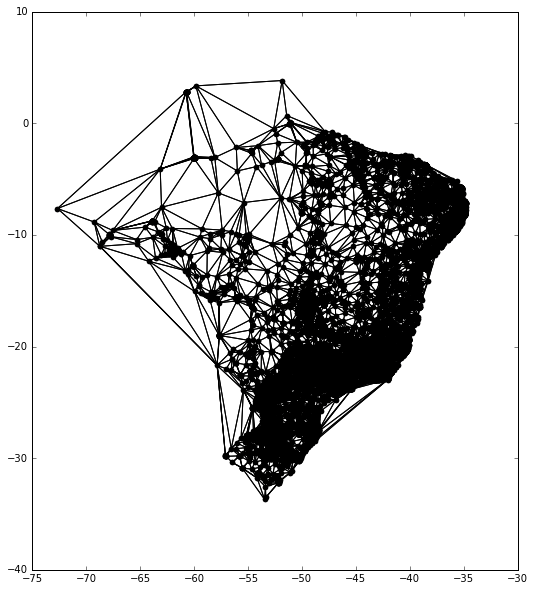

In [9]:
ord_mean['freight_value'].fillna(0, inplace=True)
y_freight = ord_mean['freight_value'].values
queen_freight = Queen.from_dataframe(ord_mean)
queen_freight.transform = 'r'
ax = ord_mean.plot(figsize=(12,10))
f,ax = queen_freight.plot(ord_mean, ax=ax)

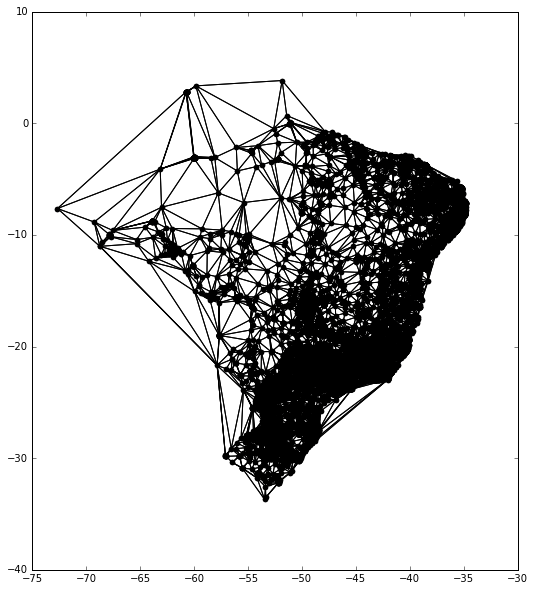

In [10]:
ord_count['order_nr'].fillna(0, inplace=True)
y_order_count = ord_count['order_nr'].values
queen_order_count = Queen.from_dataframe(ord_count)
queen_order_count.transform = 'r'
ax = ord_count.plot(figsize=(12,10))
f,ax = queen_order_count.plot(ord_count, ax=ax)

[]

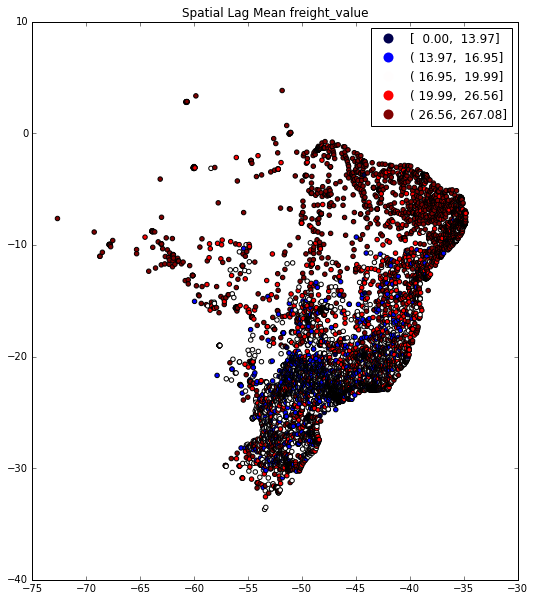

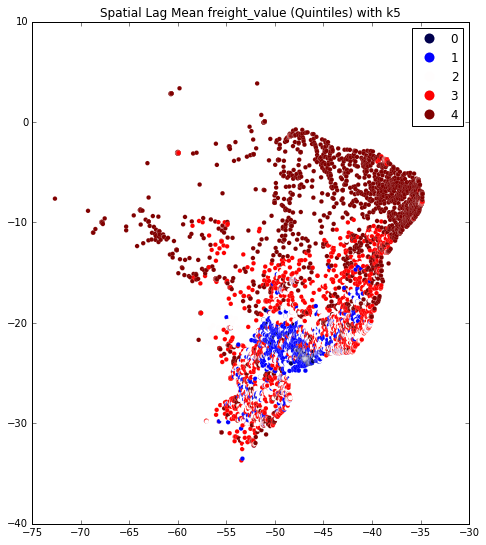

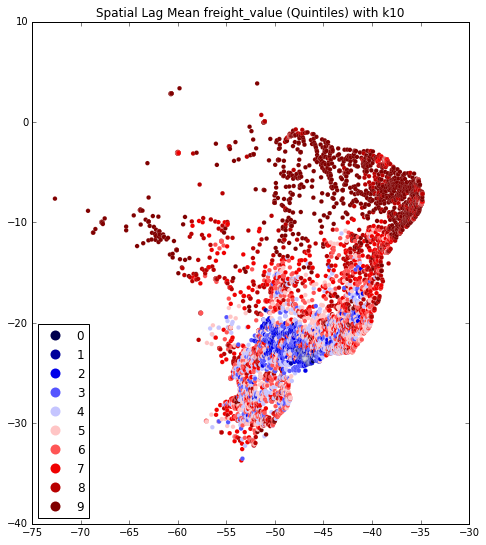

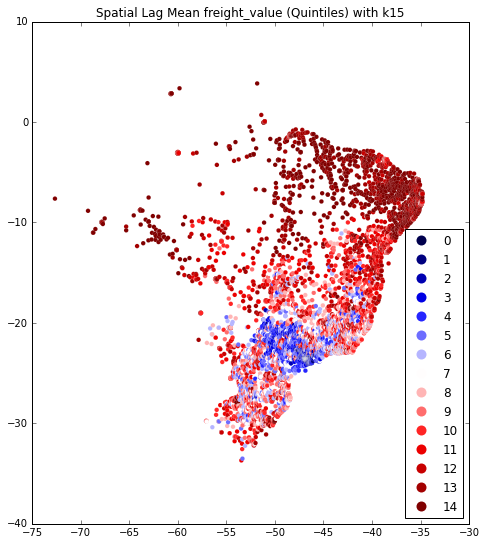

In [11]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax = ord_mean.plot(column='freight_value', scheme='Quantiles', k=5, cmap='seismic', legend=True, ax=ax)
plt.title("Spatial Lag Mean freight_value")
plt.plot()

ylag_freight = pysal.weights.lag_spatial(queen_freight,y_freight)
ylag_freight_q5 = mc.Quantiles(ylag_freight, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
ord_mean.assign(freight_value=ylag_freight_q5.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k5")
plt.plot()
ylag_freight_q10 = mc.Quantiles(ylag_freight, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
ord_mean.assign(freight_value=ylag_freight_q10.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k10")
plt.plot()
ylag_freight_q10 = mc.Quantiles(ylag_freight, k=15)
f, ax = plt.subplots(1, figsize=(9, 9))
ord_mean.assign(freight_value=ylag_freight_q10.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k15")
plt.plot()

[]

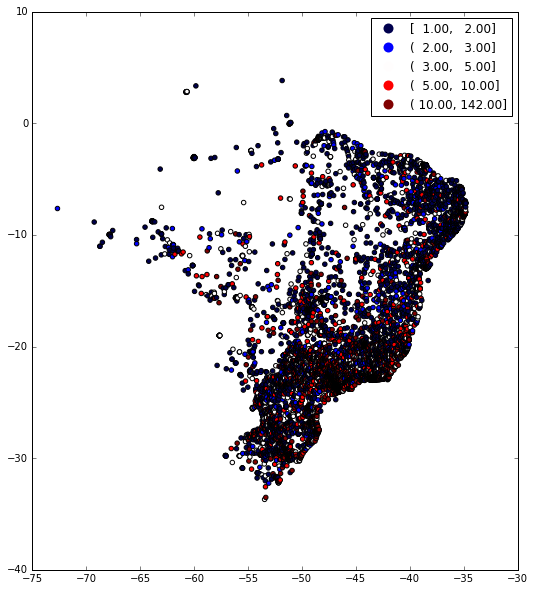

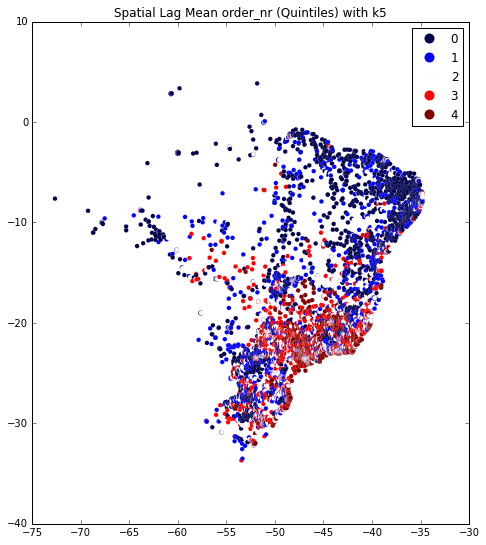

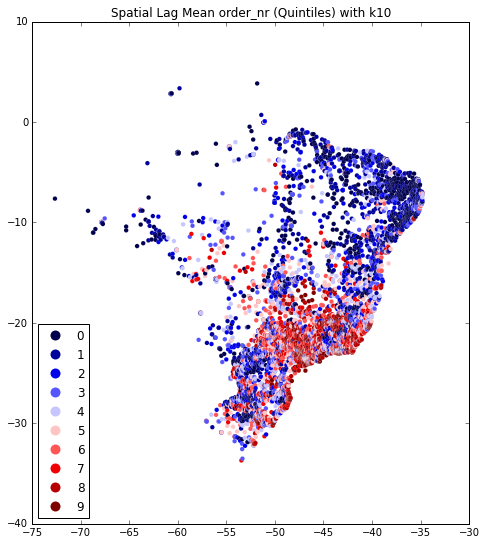

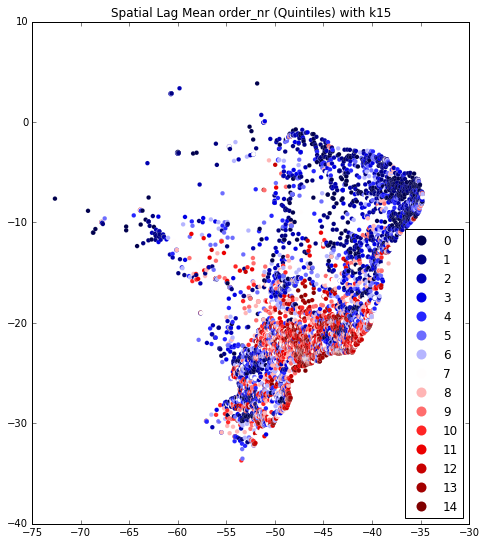

In [12]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax = ord_count.plot(column='order_nr', scheme='Quantiles', k=5, cmap='seismic', legend=True, ax=ax)

ylag_order_count = pysal.weights.lag_spatial(queen_order_count,y_order_count)
ylag_order_count_q5 = mc.Quantiles(ylag_order_count, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
ord_count.assign(order_nr=ylag_order_count_q5.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k5")
plt.plot()
ylag_order_count_q10 = mc.Quantiles(ylag_order_count, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
ord_count.assign(order_nr=ylag_order_count_q10.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k10")
plt.plot()
ylag_order_count_q15 = mc.Quantiles(ylag_order_count, k=15)
f, ax = plt.subplots(1, figsize=(9, 9))
ord_count.assign(order_nr=ylag_order_count_q15.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k15")
plt.plot()

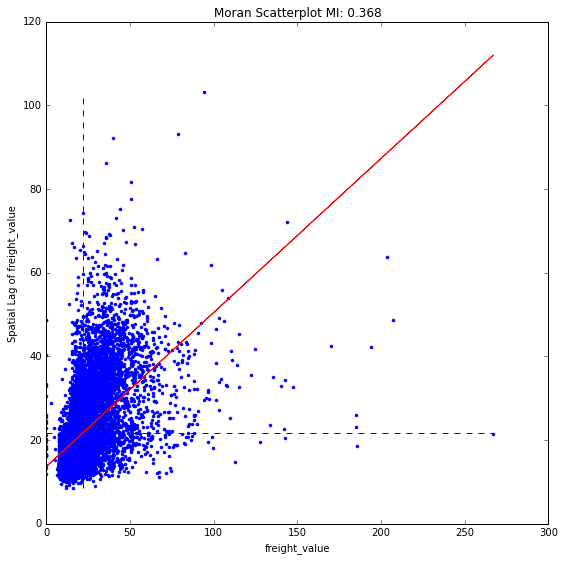

In [14]:
count = ord_mean['freight_value'].values
b, a = np.polyfit(count, ylag_freight, 1)
f, ax = plt.subplots(1, figsize=(9, 9), edgecolor='black')
mi = esda.moran.Moran(y_freight,queen_freight)
plt.plot(count, ylag_freight, '.', color='blue')
plt.vlines(count.mean(), ylag_freight.min(), ylag_freight.max(), linestyle='--')
plt.hlines(ylag_freight.mean(), count.min(), count.max(), linestyle='--')
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot MI: %1.3f' % (mi.I))
plt.ylabel('Spatial Lag of freight_value')
plt.xlabel('freight_value')
plt.show()

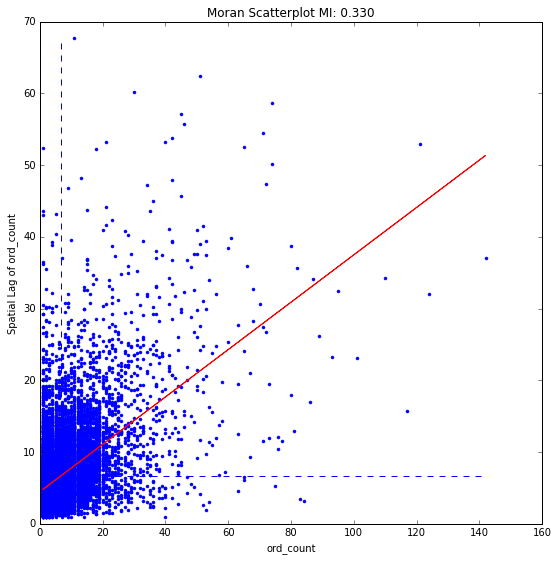

In [15]:
count = ord_count['order_nr'].values
b, a = np.polyfit(count, ylag_order_count, 1)
f, ax = plt.subplots(1, figsize=(9, 9), edgecolor='black', )
mi = esda.moran.Moran(y_order_count,queen_order_count)
plt.plot(count, ylag_order_count, '.', color='blue')
plt.vlines(count.mean(), ylag_order_count.min(), ylag_order_count.max(), linestyle='--')
plt.hlines(ylag_order_count.mean(), count.min(), count.max(), linestyle='--')
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot MI: %1.3f' % (mi.I))
plt.ylabel('Spatial Lag of ord_count')
plt.xlabel('ord_count')
plt.show()

In [ ]:
sns.lineplot(x="order_purchase_date",
             y="total_value", 
             data=pd.DataFrame(orders_customers_geo.groupby('order_purchase_date')['total_value'].sum()))

In [ ]:
y = orders_customers_geo['freight_value'].values.reshape((-1,1))
X = orders_customers_geo[['price','product_category_name','payment_type','product_width_cm','product_height_cm','product_length_cm','product_weight_g','seller_state','seller_city']].values
x_coord = orders_customers_geo['geolocation_lng']
y_coord = orders_customers_geo['geolocation_lat']
coords = pd.DataFrame(list(zip(x_coord,y_coord)))

np.random.seed(1234)
index_split = round(coords.shape[0]*0.8)